# iPhoneで撮影した動画から心拍数を計測する

#### ※このプログラムの問題点
- 動画のフレーム数が60fpsでないと精度が出にくい
- サンプリング周波数の扱い方が雑
- 肌の位置を指定できているか運次第

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns
import os
import shutil
from scipy import signal
import glob
from scipy import fftpack
from tqdm import tqdm

In [27]:
#フレーム分割
def frame_split(video_file):

    cap = cv2.VideoCapture(video_file)

    # 総フレーム数を取得する。
    total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    
    # フレームを格納する配列
    files = []
    
    i = 0
    tqdm(desc="Splitting Frame")
    for _ in tqdm(range(int(total_frame))):
        flag, frame = cap.read()  # Capture frame-by-frame
        if flag == False:  
            break
        files.append(frame)
        i += 1
    cap.release()
    return files

In [3]:
images = frame_split("IMG_5143.mov")

Splitting Frame: 0it [00:00, ?it/s]
100%|█████████▉| 2992/3002 [01:40<00:00, 17.35it/s]

In [5]:
len(images)

2998

In [6]:
images[0].shape

(1920, 1080, 3)

In [7]:
# cv2の画像は["高さ", "幅", "BGR"]で格納されている
images_green = [pd.DataFrame(images[j][:,:,1]) for j in range(len(images))]

## 解析領域を指定し，領域内のGの時間変化を求める

In [8]:
#parameter 頬の部分を指定
in1 = 1000
in2 = 1100
co1 = 250
co2 = 300

頬の部分を指定するパラメーターの確認をする

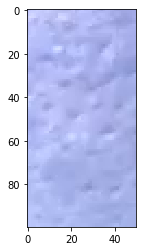

In [10]:
# 最初のフレーム
plt.imshow(images[0][ in1 : in2 , co1 :co2 ])

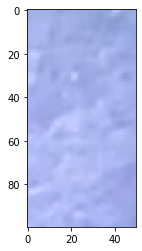

In [11]:
# 最後のフレーム
plt.imshow(images[-1][ in1 : in2 , co1 :co2 ])

In [12]:
#メディアンフィルタによる平滑化
images_green_median = [cv2.medianBlur(images_green[i].iloc[ in1 : in2 , co1 :co2 ].values,ksize=5)  for i in range(len(images_green))]

#平均値を算出
img_mean = [images_green_median[i].mean()  for i in range(len(images_green_median))]

Text(0.5, 1.0, 'Transition of Green Value')

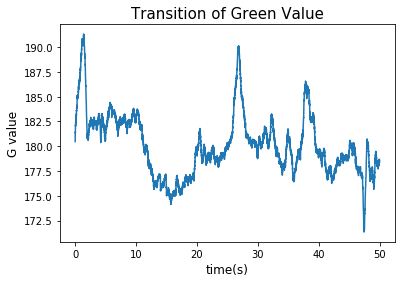

In [24]:
# 今回は60fpsで撮影した
num_frames = 60

end_time = round(len(img_mean)/num_frames)
time = np.arange(0 , end_time , end_time/len(img_mean))

# 横軸を時間、縦軸をG値として描画する
plt.plot(time, img_mean)
plt.xlabel("time(s)", size=12)
plt.ylabel("G value", size=12)
plt.title("Transition of Green Value", size=15)

## パワースペクトルを求める


一般的に人間の心拍数は60〜100bpmである。

大きく見積もって40〜150bpmを捉えられるようにすると、周期は0.4〜1.6sとなる。（周波数は0.7〜2.5Hz）よって最大周期1.6sを10周期分入れるとすれば、解析窓長は16s必要になる。

In [25]:
#サンプリング周波数
fs = 60

#パワースペクトルを求める関数を定義
def signal_fft (data,fs):
    n = len(data)-1
    y = fftpack.fft(data)/n
    y = y[0:round(n/2)]
    power = 2*(np.abs(y)**2)
    power = 10*np.log10(power)
    f = np.arange(0,fs/2,fs/n)
    return power, f

#15sの窓でパワースペクトル算出
time_interval = 16
loop_len = list(range(round(len(img_mean)/(fs*time_interval))))
fft_result = []
for n,i in enumerate(loop_len):
    if n ==0:
        img = img_mean[:time_interval*fs]
        fft_result.append(signal_fft(img,fs))
    else :
        img = img_mean[time_interval*fs*n : time_interval*fs*(n+1)]
        fft_result.append(signal_fft(img,fs)) 

#周波数フィルタリング（0.7-2.5Hzの値のみ抽出）
data = []
for j in range(len(fft_result)):
    fft_data = [fft_result[j][0][n] for n,i in enumerate(fft_result[j][1]) if 0.7< i < 2.5]
    data.append(fft_data)
frequ = [i for n,i in enumerate(fft_result[0][1]) if 0.7< i < 2.5]

## ピーク周波数から脈拍数を算出

In [19]:
data = np.array(data)
#ピークのindexを取得
peak_index  = [np.array(data[i]).argmax() for i in range(len(data))]

#取得したindexから該当の周波数を取得し心拍数に変換
heart_rate = [round(frequ[i]*fs) for i in peak_index]

# 平均値を出力する
print("heart rate:{:.2f}".format(np.mean(heart_rate)))

heart rate:57.33
